# Artificial Neural Networks 

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import sklearn.metrics
import torch.optim as optim
import shap
import optuna
import pickle

## Data Preparation

In [2]:
df = pd.read_csv('Data/voice.csv')
df['label'] = df['label'].replace("male", "0")
df['label'] = df['label'].replace("female", "1")
df['label'] = df['label'].astype(int)

In [3]:
train, validate, test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

In [4]:
x_train = train.iloc[:,:-1]
y_train = train.label
x_test = test.iloc[:,:-1]
y_test = test.label
x_val = validate.iloc[:,:-1]
y_val = validate.label

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
x_val = sc.fit_transform(x_val)

In [5]:
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.float32)
        self.length = self.x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.length

trainset = dataset(x_train, y_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=False)

testset = dataset(x_test, y_test)
testloader = DataLoader(testset, batch_size=8, shuffle=False)

valset = dataset(x_val, y_val)
valloader = DataLoader(valset, batch_size=8, shuffle=False)

## Methodology

In [6]:
# Hyper Parameters
learning_rate = 0.035
epochs = 65
momentum = 0.04170000000000001
patience = 11
dropout_rate = 0.3635

In [7]:
class GenderClassificationModel(torch.nn.Module):    
    def __init__(self, input_shape, trials = None):
        super().__init__()
        if trials:
            learning_rate = trials.suggest_float("learning_rate", 0.0001, 1, step = 0.0001)
            epochs = trials.suggest_int("epochs", 20, 100)
            momentum = trials.suggest_float("momentum", 0.0001, 1, step = 0.0001)
            patience = trials.suggest_int("patience", 10, 50)
            dropout_rate = trials.suggest_float("dropout_rate", 0.0001, 1, step = 0.0001)
    
        self.fc1 = torch.nn.Linear(input_shape, 32)
        self.fc2 = torch.nn.Linear(32, 64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        if self.training:
            x = torch.nn.functional.dropout(x, dropout_rate)

        return torch.sigmoid(self.fc3(x))

In [8]:
model = GenderClassificationModel(input_shape = x_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum)
loss_fn = torch.nn.BCELoss()

## Hyperparameter Optimization

In [19]:
def objective(trial):
    model = GenderClassificationModel(x_train.shape[1], trial)
    
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', "SGD"])
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        for j, (x, y) in enumerate(trainloader):
            model.train()
            output = model(x)

            loss = loss_fn(output, y.reshape(-1, 1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                for j, (x, y) in enumerate(valloader):
                    output = model(x)
                    loss = loss_fn(output, y.reshape(-1, 1))

                    predicted = model(torch.tensor(x_val, dtype = torch.float32))
                    acc = (predicted.reshape(-1).detach().numpy().round() == y_val).mean()

        trial.report(acc, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return acc


In [9]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials=100)

trial = study.best_trial
print(f'Accuracy: {trial.value}')
print(f'Best Hyperparameters: {trial.params}')

[I 2023-01-16 15:08:51,876] A new study created in memory with name: no-name-96d49291-2eb4-4bb4-8a46-094ef0aca3ed


NameError: name 'objective' is not defined

## Training

In [10]:
train_losses = []
train_accur = []
val_losses = []
val_accur = []
test_losses = []
test_accur = []

best_val_acc = 0.0

for i in range(epochs):
    for j, (x, y) in enumerate(trainloader):
        model.train()
        output = model(x)

        loss = loss_fn(output, y.reshape(-1, 1))

        predicted = model(torch.tensor(x_train, dtype = torch.float32))
        acc = (predicted.reshape(-1).detach().numpy().round() == y_train).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_losses.append(loss.detach().numpy())
    train_accur.append(acc)

    if i>0 and i % 10 == 0:
        print("epoch {}\ttraining_loss : {}\t training_accuracy : {}".format(i,loss,acc))
        

    model.eval()
    with torch.no_grad():
        for j, (x, y) in enumerate(valloader):
            output = model(x)
            loss = loss_fn(output, y.reshape(-1, 1))

            predicted = model(torch.tensor(x_val, dtype = torch.float32))
            acc = (predicted.reshape(-1).detach().numpy().round() == y_val).mean()

        if acc > best_val_acc:
            torch.save(model, 'Models/ANN.pth')
            best_val_acc = acc
            num_bad_epochs = 0
        else:
            num_bad_epochs += 1
            if num_bad_epochs == patience:
                break

        val_accur.append(acc)
        val_losses.append(loss)

best_model = torch.load('Models/ANN.pth')
pickle.dump(best_model, open("Models/ANN.pickle", "wb"))

    

epoch 10	training_loss : 0.023922225460410118	 training_accuracy : 0.9715864246250987
epoch 20	training_loss : 0.013899183832108974	 training_accuracy : 0.9802683504340963
epoch 30	training_loss : 0.01484630722552538	 training_accuracy : 0.9834254143646409


## Hyperparameter Optimization Evaluation
### Parameter Importance 

In [21]:
optuna.visualization.plot_param_importances(study)

## Feature Importance


## Training Evaluation
### Change is Loss over Epochs

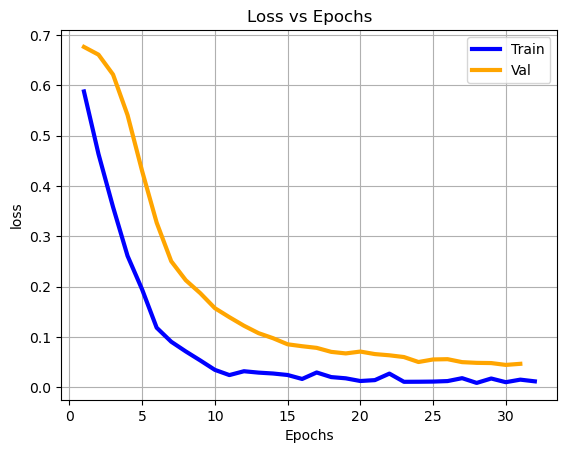

In [11]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Loss vs Epochs')
ax.plot(range(1, len(train_losses) + 1), train_losses, color='blue', linestyle='-', linewidth=3, label = "Train")
ax.plot(range(1, len(val_losses) + 1), val_losses, color='orange', linestyle='-', linewidth=3, label = "Val")
ax.legend()
ax.grid()

### Change in Accuracy over Epochs

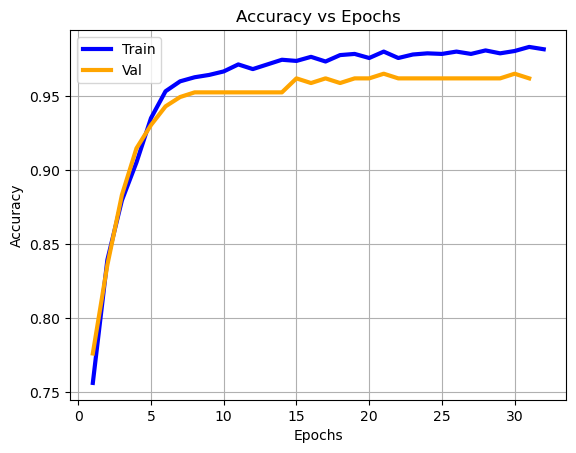

In [12]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Epochs')
ax.plot(range(1, len(train_accur) + 1), train_accur, color='blue', linestyle='-', linewidth=3, label = "Train")
ax.plot(range(1, len(val_accur) + 1), val_accur, color='orange', linestyle='-', linewidth=3, label = "Val")
ax.legend()
ax.grid()
           

## Outcome Evaluation
### Accuracy

In [13]:
with torch.no_grad():
    predicted = best_model(torch.tensor(x_test, dtype = torch.float32))
    acc = (predicted.reshape(-1).detach().numpy().round() == y_test).mean()
    print(f"Accuracy: {100*acc}%")

Accuracy: 97.47634069400631%


### Confusion Matrix 

In [14]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}
plt.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


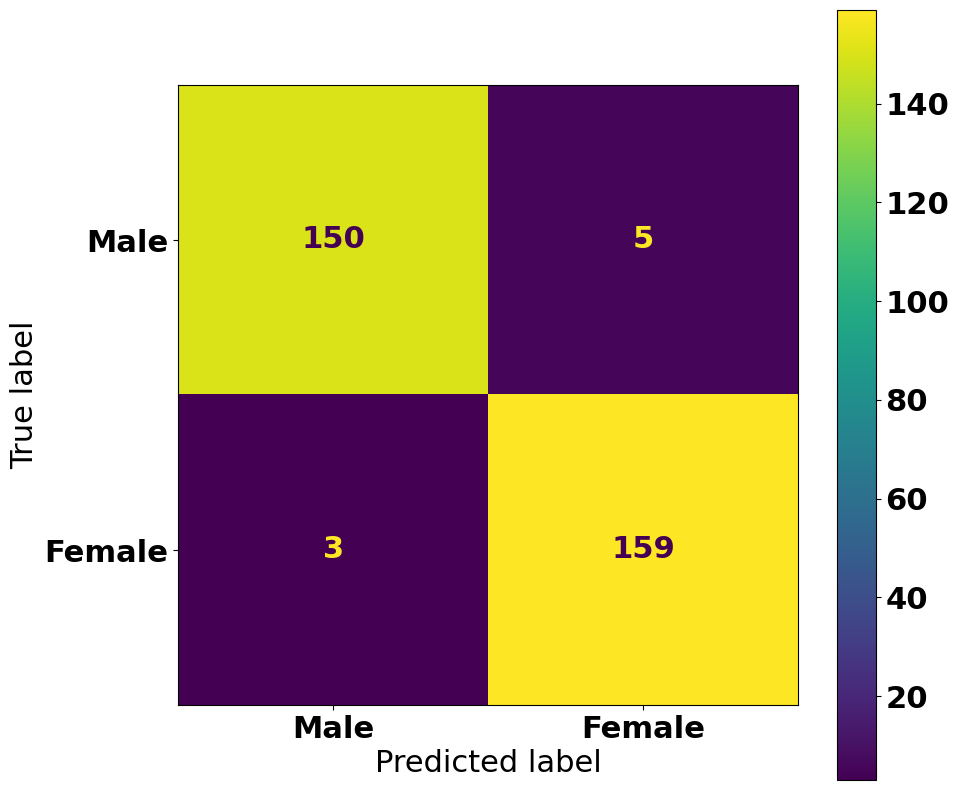

In [15]:
with torch.no_grad():
    predictions = best_model(torch.tensor(x_test, dtype = torch.float32))
    predictions = np.round(predictions.numpy())
    c = sklearn.metrics.confusion_matrix(y_test, predictions)
    cp = sklearn.metrics.ConfusionMatrixDisplay(c, display_labels=["Male", "Female"])
    fig, ax = plt.subplots(figsize=(10,10))
    cp.plot(ax = ax)

### Classification Report

In [11]:
with torch.no_grad():
    predictions = best_model(torch.tensor(x_test, dtype = torch.float32))
    predictions = np.round(predictions.numpy())
    print("\t\t\tANN report:\n",sklearn.metrics.classification_report(predictions,y_test, digits=3))

			ANN report:
               precision    recall  f1-score   support

         0.0      0.987     0.957     0.972       162
         1.0      0.956     0.987     0.971       155

    accuracy                          0.972       317
   macro avg      0.972     0.972     0.972       317
weighted avg      0.972     0.972     0.972       317

